In [1]:
import os
from typing import Optional, List
from tabulate import tabulate

In [2]:
from PIL import Image, ImageDraw, ImageFont
from PIL import features
import matplotlib.pyplot as plt

In [3]:
print(f"Raqm (complex text) support is enabled: {features.check('raqm')}")

Raqm (complex text) support is enabled: True


In [4]:
# IMPORTANT: Provide the path to the Devanagari font you downloaded.
HINDI_FONT_FILE = "/Users/niteshkumarsharma/Downloads/Noto_Sans_Devanagari/static/NotoSansDevanagari_ExtraCondensed-Medium.ttf"
try:
    # Test if the font file is accessible
    ImageFont.truetype(HINDI_FONT_FILE, size=15)
    print(f"Successfully loaded Hindi font: {HINDI_FONT_FILE}")
except IOError:
    print(f"ERROR: Hindi font not found at '{HINDI_FONT_FILE}'.")
    print("Please download it from fonts.google.com and place it in the script's directory.")
    HINDI_FONT_FILE = None 

Successfully loaded Hindi font: /Users/niteshkumarsharma/Downloads/Noto_Sans_Devanagari/static/NotoSansDevanagari_ExtraCondensed-Medium.ttf


In [5]:
from dotenv import load_dotenv

In [6]:
from google.api_core.client_options import ClientOptions
from google.cloud import documentai_v1

In [7]:
PROJECT_ID = os.getenv("PROJECT_ID", "")
API_LOCATION = os.getenv("API_LOCATION", "")

In [8]:
indic_parser_name = "indic_test_processor"

In [9]:
opts = ClientOptions(api_endpoint=f"{API_LOCATION}-documentai.googleapis.com")

In [10]:
client = documentai_v1.DocumentProcessorServiceClient(client_options=opts)

In [11]:
full_processor_name = client.processor_path(PROJECT_ID, API_LOCATION, "5945bfe7932ca5b7")

In [12]:
request = documentai_v1.GetProcessorRequest(name=full_processor_name)
processor = client.get_processor(request=request)

In [92]:
file_path = "/Users/niteshkumarsharma/Desktop/Folder/AI/indic_document_extraction/sample_images/hindi/book_scanned_hindi_12.png"
# Read the file into memory.
with open(file_path, "rb") as image:
    image_content = image.read()

In [93]:
raw_document = documentai_v1.RawDocument(
    content=image_content,
    mime_type="image/png",
)

In [94]:
request = documentai_v1.ProcessRequest(name=processor.name, raw_document=raw_document)
result = client.process_document(request=request)
document = result.document

In [95]:
def draw_bounding_poly(draw, bounding_poly, width, height, color, line_width):
    """Helper function to draw a single bounding polygon."""
    polygon = [
        (vertex.x * width, vertex.y * height)
        for vertex in bounding_poly.normalized_vertices
    ]
    draw.polygon(polygon, outline=color, width=line_width)

In [96]:
def visualize_document_hierarchy(
    image_path: str, 
    document: documentai_v1.Document,
    levels_to_show: Optional[List[str]] = None
):
    """
    Draws bounding boxes for the specified hierarchy levels.

    Args:
        image_path: The path to the original image file.
        document: The Document object returned by the Document AI API.
        levels_to_show: A list of levels to visualize.
                        Options: 'block', 'paragraph', 'line', 'token'.
                        If None, all levels are shown.
    """
    if levels_to_show is None:
        # Default to showing all levels if none are specified
        levels_to_show = ['block', 'paragraph', 'line', 'token']
    
    # Use a set for efficient "in" checks
    levels_to_show_set = set(levels_to_show)
    print(f"Visualizing hierarchy for levels: {', '.join(levels_to_show)}")

    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Define styles for each level
    styles = {
        'block': {'color': 'blue', 'width': 2},
        'paragraph': {'color': 'red', 'width': 4},
        'line': {'color': 'green', 'width': 3},
        'token': {'color': 'black', 'width': 1},
    }

    for page in document.pages:
        # Order matters for layering: draw largest elements first.
        # We iterate through this fixed order and check if the level is requested.
        for element_type_plural, level_key in [
            ('blocks', 'block'), 
            ('paragraphs', 'paragraph'), 
            ('lines', 'line'), 
            ('tokens', 'token')
        ]:
            if level_key in levels_to_show_set:
                for element in getattr(page, element_type_plural):
                    draw_bounding_poly(
                        draw,
                        element.layout.bounding_poly,
                        width,
                        height,
                        styles[level_key]['color'],
                        styles[level_key]['width']
                    )
    return image, levels_to_show

In [97]:
output_image, shown_levels = visualize_document_hierarchy(
    file_path, 
    document, 
    levels_to_show=['block'])

Visualizing hierarchy for levels: block


Displaying the image with selected bounding boxes...


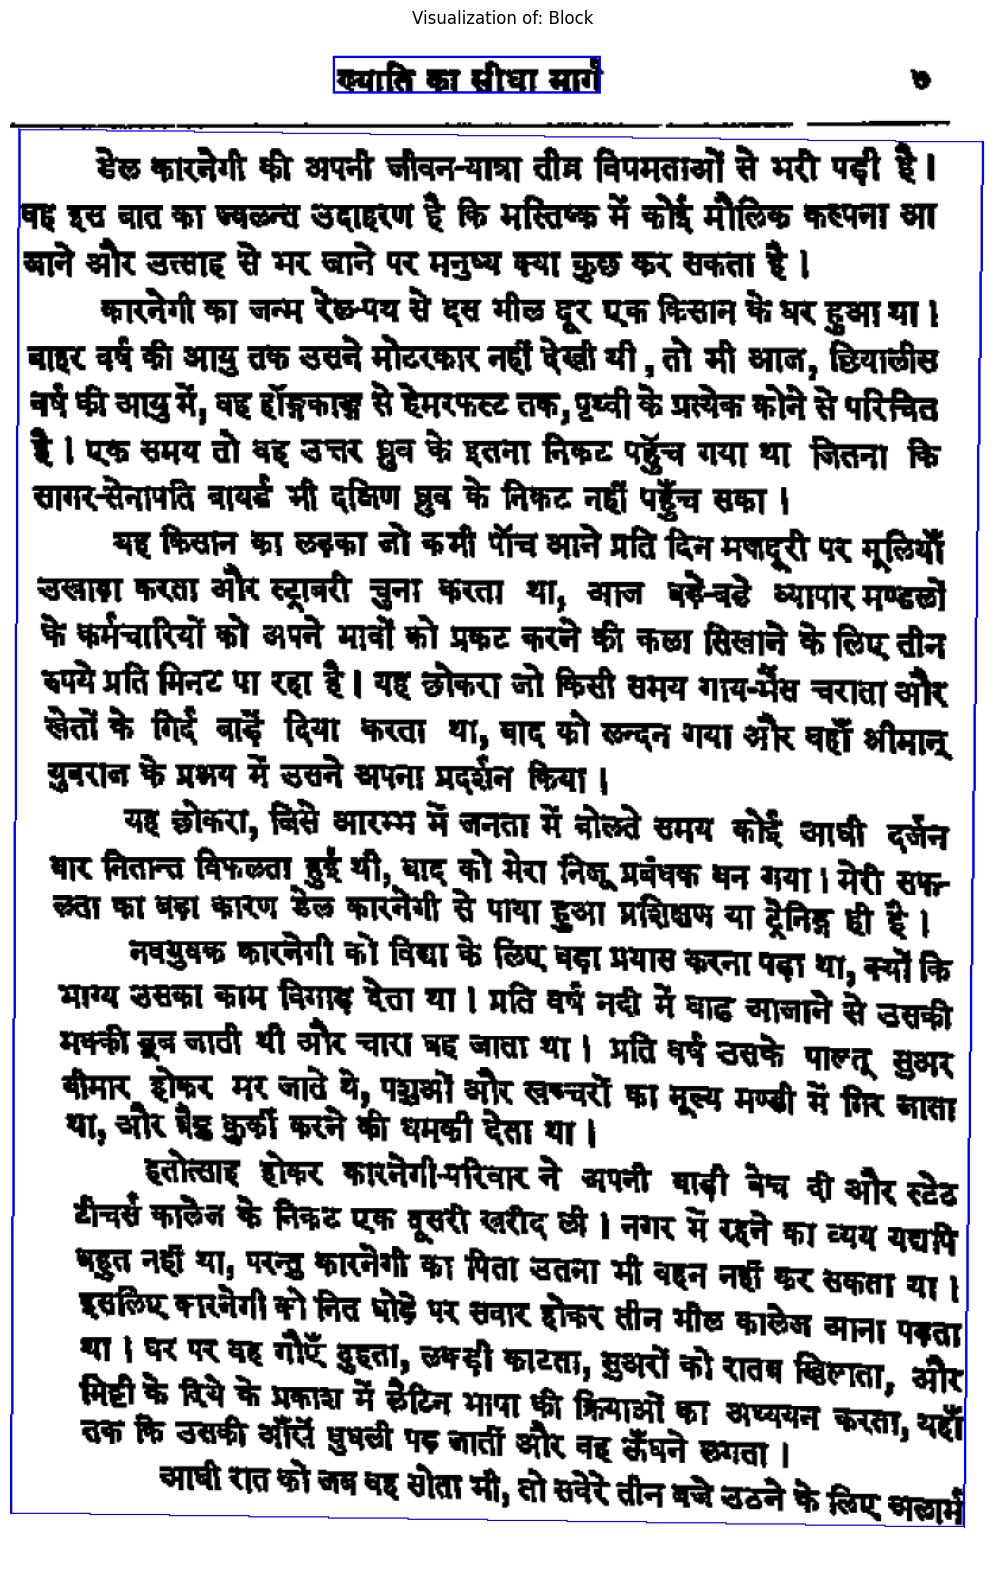

In [98]:
print("Displaying the image with selected bounding boxes...")
plt.figure(figsize=(20, 20))
plt.imshow(output_image)
# Create a dynamic title based on what was shown
title = f"Visualization of: {', '.join(s.title() for s in shown_levels)}"
plt.title(title)
plt.axis("off")
plt.show()

In [105]:
def visualize_tokens_on_blank(
    image_path: str, 
    document: documentai_v1.Document
):
    """
    Draws token bounding boxes and text on a blank white canvas that has the
    same dimensions as the original image.
    """
    # KEY CHANGE: Get dimensions from original image first.
    # We use a 'with' block to ensure the file is closed properly.
    with Image.open(image_path) as original_image:
        width, height = original_image.size

    # KEY CHANGE: Create a new blank white image.
    # The 'L' mode creates an 8-bit grayscale image, which is fine for black/white.
    # Use "RGB" for color drawing. "white" sets the background color.
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)
    
    print("Visualizing tokens on a new blank canvas...")

    for page in document.pages:
        for token in page.tokens:
            layout = token.layout
            
            # Bounding box coordinates are calculated the same way
            polygon = [
                (vertex.x * width, vertex.y * height)
                for vertex in layout.bounding_poly.normalized_vertices
            ]
            # Draw the box on our blank canvas
            # draw.polygon(polygon, outline="black")
            
            # Text extraction logic is the same
            text_anchor = layout.text_anchor
            token_text = document.text[text_anchor.text_segments[0].start_index : text_anchor.text_segments[0].end_index]

            # Font sizing and loading logic is the same
            box_height = polygon[3][1] - polygon[0][1]
            font_size = max(int(box_height * 0.9), 10)
            font_size = 22
            
            if HINDI_FONT_FILE:
                font = ImageFont.truetype(HINDI_FONT_FILE, size=font_size)
            else:
                font = ImageFont.load_default(size=font_size)

            text_position = (polygon[0][0], polygon[0][1])
            
            # Draw the text on our blank canvas
            draw.text(
                text_position, 
                token_text, 
                fill="black",  # Using black text for better contrast on white
                font=font,
                layout_engine=ImageFont.Layout.RAQM
            )
            
    return image

Visualizing tokens on a new blank canvas...
Displaying the image with token text...


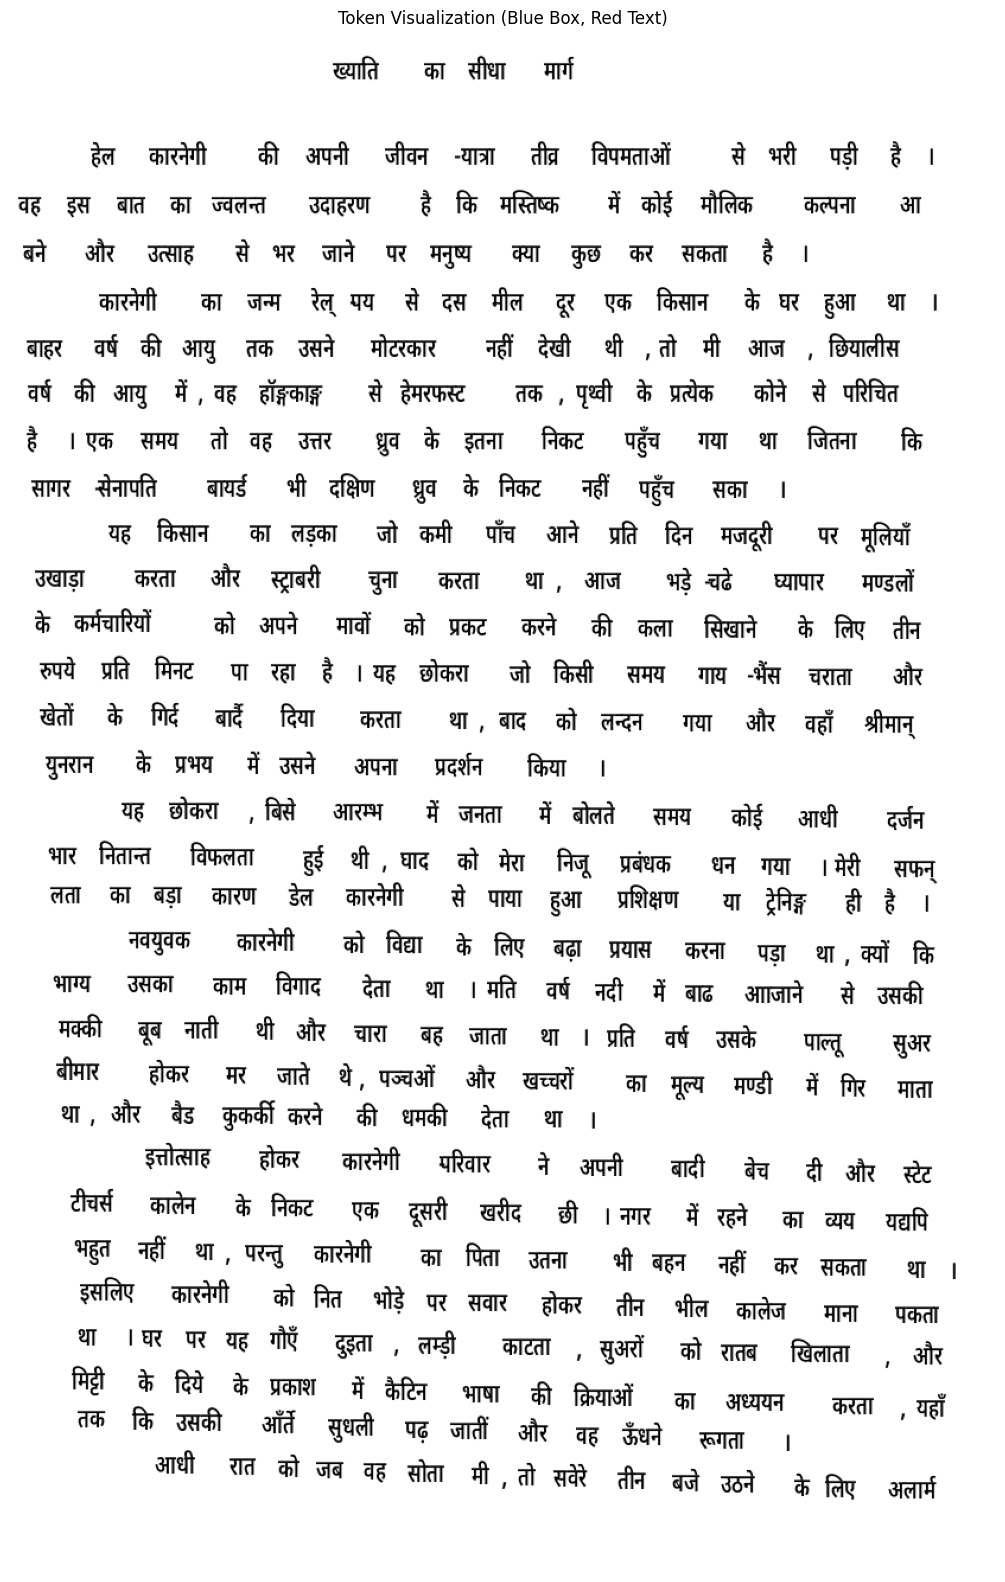

In [106]:
# Call the new visualization function
output_image_tokens = visualize_tokens_on_blank(file_path, document)

# Display the image using Matplotlib
print("Displaying the image with token text...")
plt.figure(figsize=(20, 20))
plt.imshow(output_image_tokens)
plt.title("Token Visualization (Blue Box, Red Text)")
plt.axis("off")
plt.show()

Displaying images side-by-side...


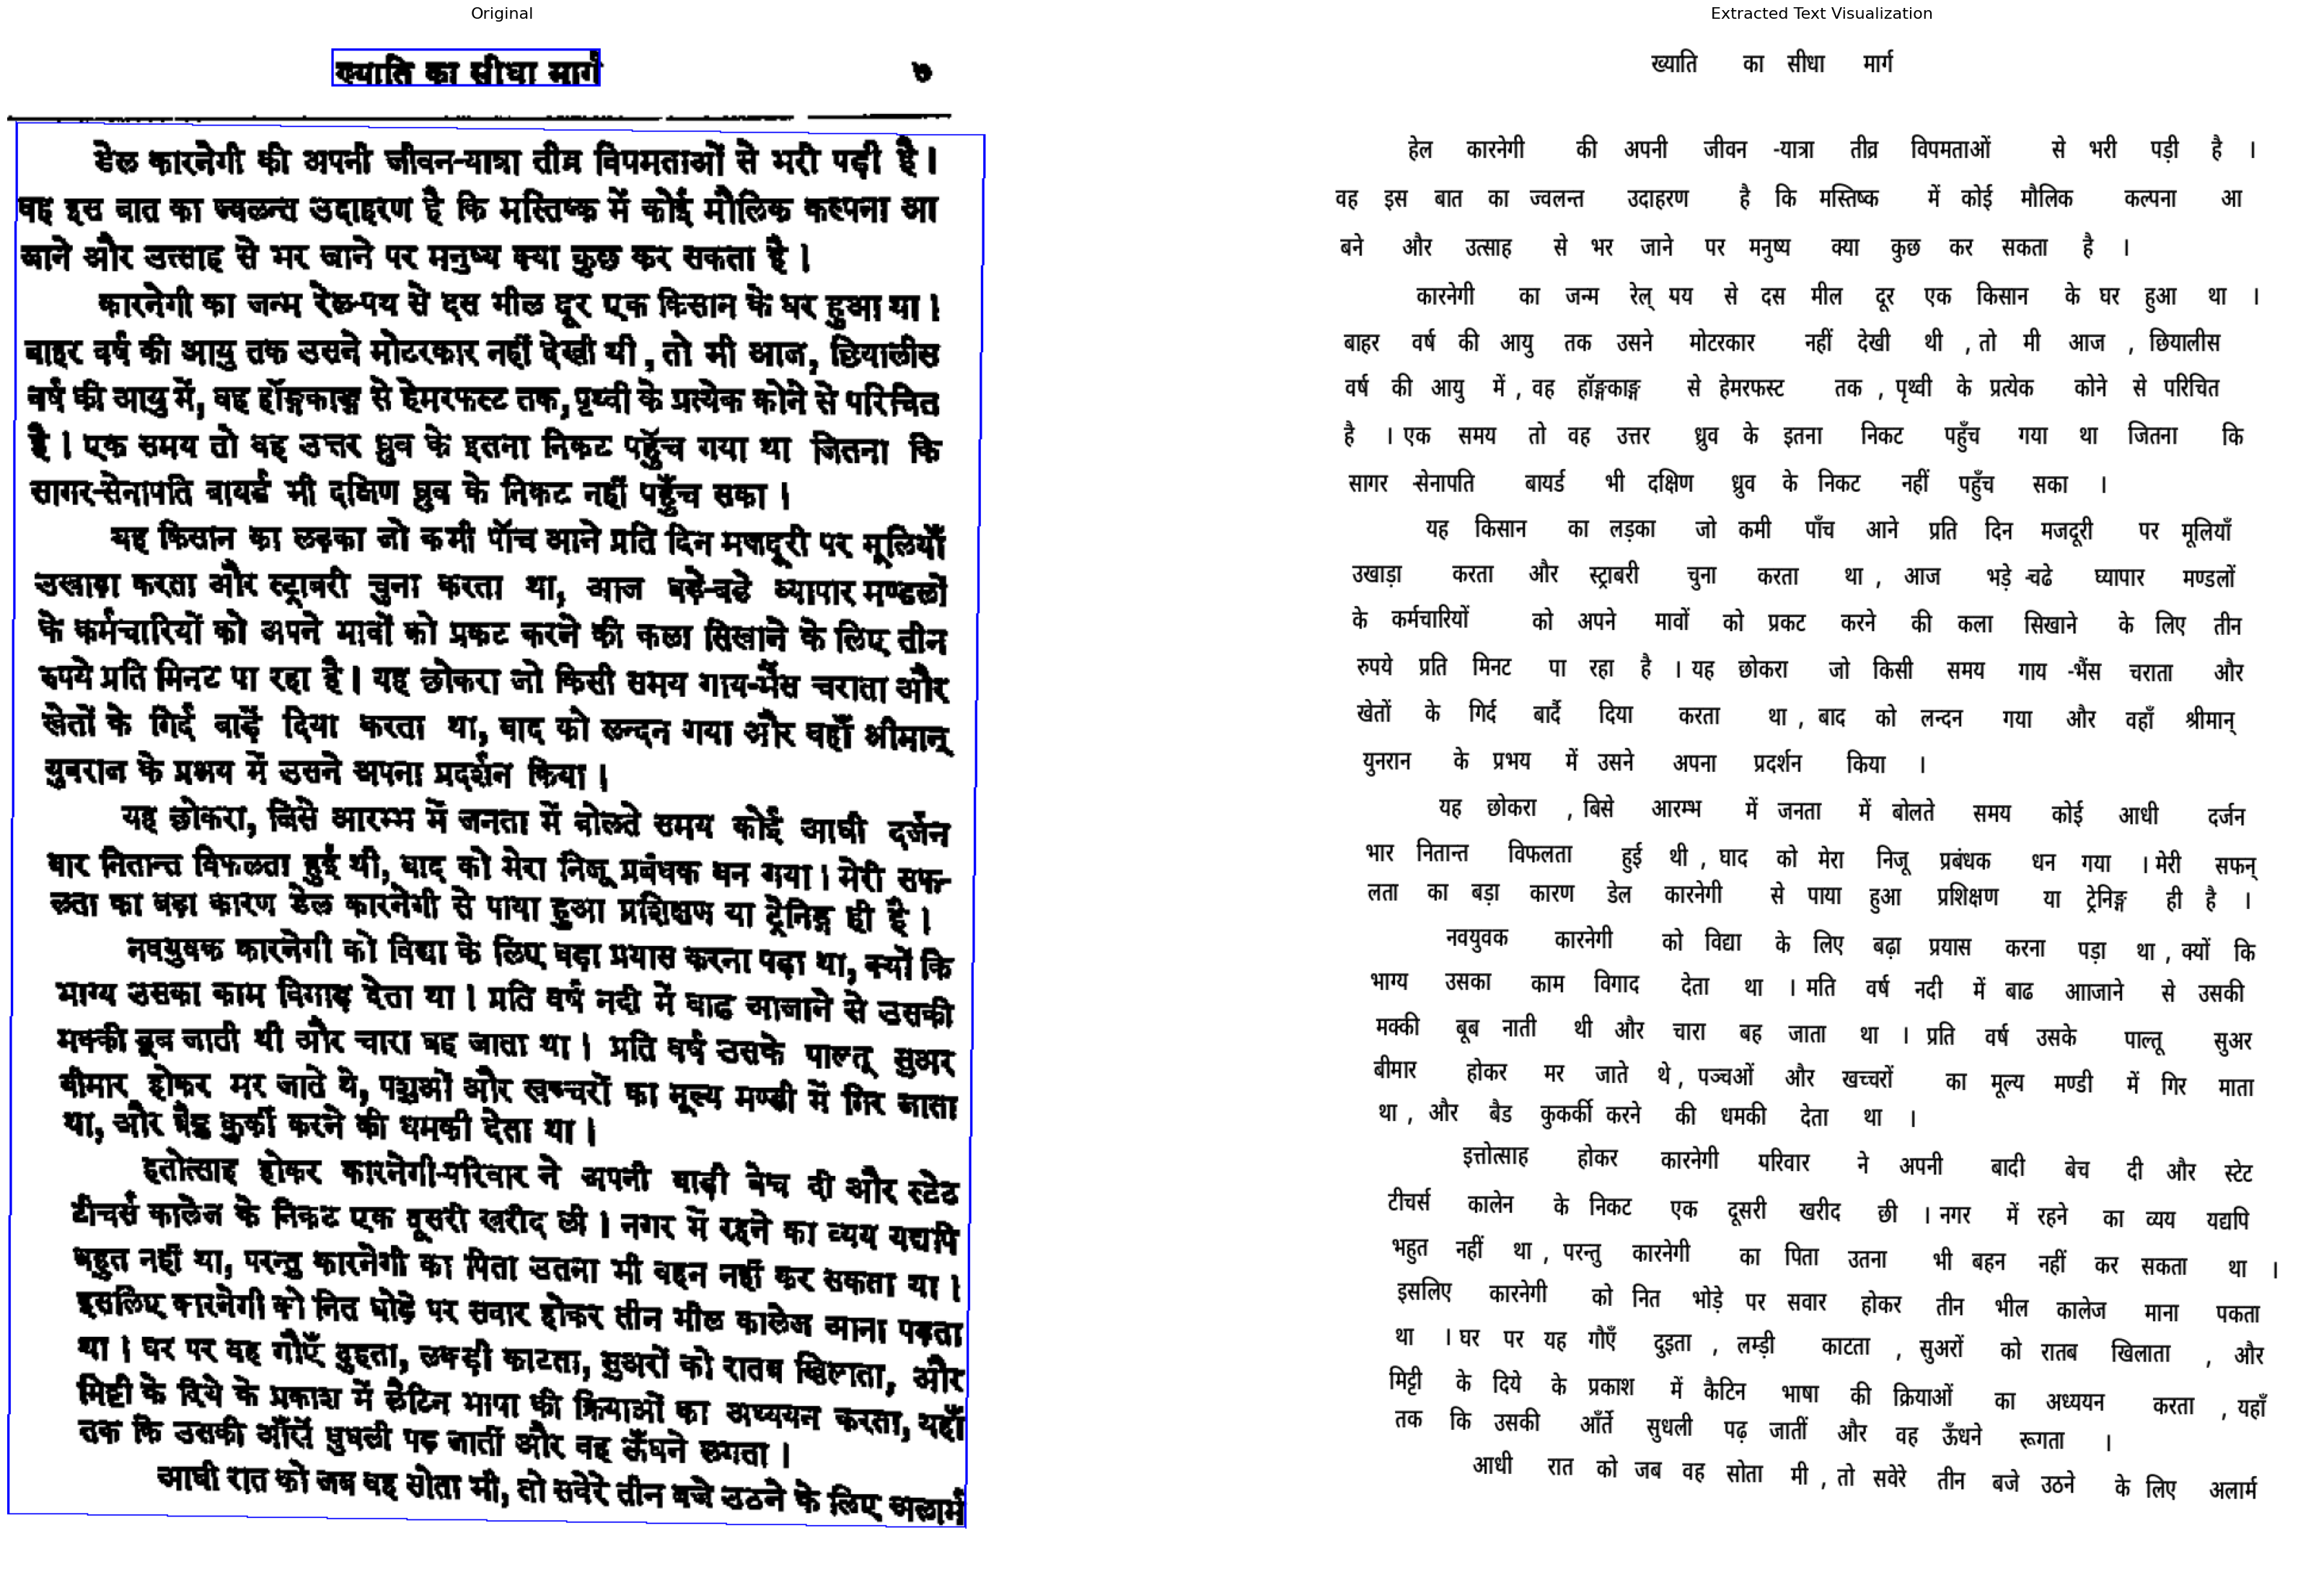

In [107]:
print("Displaying images side-by-side...")

# Create a figure and a set of subplots. 
# plt.subplots(nrows, ncols, ...). Here we want 1 row, 2 columns.
# It returns the figure and an array of axes.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 22))

# --- Plot on the first axis (left) ---
ax1.imshow(output_image)
ax1.set_title("Original", fontsize=16)
ax1.axis('off')  # Hide the x and y axis ticks

# --- Plot on the second axis (right) ---
ax2.imshow(output_image_tokens)
ax2.set_title("Extracted Text Visualization", fontsize=16)
ax2.axis('off')  # Hide the x and y axis ticks

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Show the entire figure with both subplots
plt.show()
